# **<font color="#A41034">Language Model using Transformer</font>**

<hr style="height:2pt">

## **<font color="#A41034">Setup Notebook</font>**

**Copy & setup Colab with GPU**

1) Select "File" menu and pick "Save a copy in Drive"  
2) This notebooks is already setup to use GPU but if you want to change it. Go to "Runtime" menu and select "Change runtime type". Then in the popup in "Hardware accelerator" select "GPU" and then click "Save"   

**Imports**

In [ ]:
# Imports
import os
import time
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow.python.keras import backend as K

# sklearn
from sklearn.decomposition import PCA

**Verify Setup**

It is a good practice to verify what version of TensorFlow & Keras you are using. Also verify if GPU is enabled and what GPU you have. Run the following cells to check the version of TensorFlow

References:
- [Eager Execution](https://www.tensorflow.org/guide/eager)
- [Data Performance](https://www.tensorflow.org/guide/data_performance)

In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately,
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.9.2
keras version 2.9.0
Eager Execution Enabled: True
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Run this cell to see what GPU you have. If you get a A100, V100, P100 or T4 GPU that's great. If it's K80, it will still work but it will be slow.

In [ ]:
!nvidia-smi

Sat Dec  3 12:09:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    30W /  70W |    314MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **<font color="#A41034">Language Modeling</font>**

### **Overview**

In this tutorial, we're going to be working with some text related to machine & deep learning. The data is a very small set of defintions pulled form wikipedia. The primary goal will be to understand Multi Head Attention Layers and Transformer architecture.

**The Task:** Language modeling to learn how words appear in context to one another. The model is trained using an unsupervised/semi supervised approach. For this tutorial we do not mask words but in reality you would mask words and this approach would be called masked language modeling

### **[Dataset](#scrollTo=dataset)**

The dataset consists of text related to machine & deep learning. The data is a very small set of defintions pulled form wikipedia.

#### **Load Data**

* Read-in the data

In [ ]:
# Dowload the dataset
file_path = "https://storage.googleapis.com/cs109b/nlp/deep_learning_sentences.csv"
data = pd.read_csv(file_path, encoding='latin1')
print("Shape:",data.shape)
data.head()

Shape: (182, 1)


,sentence
0,Deep learning also known as deep structured le...
1,"Learning can be supervised, semi-supervised or..."
2,Deep-learning architectures such as deep neura...
3,Artificial neural networks (ANNs) were inspire...
4,ANNs have various differences from biological ...


In [ ]:
# Get sentences
sentences = data["sentence"].values.tolist()

# Add a DEMO sentence
sentences.append("pavlos taught positional encoding to shivas")
print("sentences len:", len(sentences))

sentences len: 183


### **Build Data Pipelines**

#### **Text Vectorization**

In [ ]:
sequence_length = max([len(x.split()) for x in sentences])
print("sequence_length",sequence_length)

def standardize_text(input_text):
  # Convert to lowercase
  output_text = tf.strings.lower(input_text)
  return tf.strings.regex_replace(
        output_text, "[%s]" % re.escape("!#$%&'()*+,-.:;=?@\^_`{|}~"), ""
    )

text_data = tf.data.Dataset.from_tensor_slices(sentences)

# Initialize Text Vectorizer
text_vectorizer = tf.keras.layers.TextVectorization(
    standardize=standardize_text,
    output_mode="int",
    output_sequence_length=sequence_length
)

# Generate Text Vector
text_vectorizer.adapt(sentences)

# Get Vocabulary
vocabulary = text_vectorizer.get_vocabulary()
vocabulary_size = len(vocabulary)

# Generate word index
word_index = dict(zip(vocabulary, range(vocabulary_size)))
index_word = dict(zip(range(vocabulary_size), vocabulary))
print("vocabulary:",len(vocabulary),vocabulary)
print("word_index:",word_index)

sequence_length 66
vocabulary: 1130 ['', '[UNK]', 'the', 'of', 'a', 'to', 'and', 'is', 'in', 'learning', 'that', 'as', 'or', 'data', 'can', 'with', 'neural', 'networks', 'be', 'language', 'such', 'an', 'are', 'machine', 'image', 'from', 'for', 'network', 'this', 'model', 'on', 'layers', 'it', 'artificial', 'training', 'deep', 'by', 'also', 'recognition', 'layer', 'computer', 'used', 'natural', 'input', 'have', 'which', 'translation', 'not', 'neurons', 'where', 'process', 'human', 'between', 'words', 'vision', 'supervised', 'speech', 'processing', 'field', 'feature', 'systems', 'recurrent', 'output', 'nlg', 'more', 'its', 'intelligence', 'each', 'understanding', 'tasks', 'signal', 'representation', 'other', 'one', 'labeled', 'known', 'into', 'images', 'different', 'biological', 'algorithms', 'when', 'visual', 'unsupervised', 'they', 'than', 'segmentation', 'produce', 'models', 'lstm', 'information', 'but', 'use', 'through', 'system', 'set', 'sequences', 'semisupervised', 'rnns', 'only',

In [ ]:
# Convert input text to tokens
all_data_tokens = text_vectorizer(sentences)
print("Input text:\n")
print(sentences[0])
print(sentences[1])
print(sentences[3])
print("all_data_tokens shape:",all_data_tokens.shape)
print("Tokenized text:", all_data_tokens[:5,:20])

Input text:

Deep learning also known as deep structured learning is part of a broader family of machine learning methods based on artificial neural networks with representation learning.
Learning can be supervised, semi-supervised or unsupervised.
Artificial neural networks (ANNs) were inspired by information processing and distributed communication nodes in biological systems.
all_data_tokens shape: (183, 66)
Tokenized text: tf.Tensor(
[[  35    9   37   75   11   35  192    9    7  150    3    4 1048  879
     3   23    9  101  109   30]
 [   9   14   18   55   97   12   83    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [ 961  428   20   11   35   16   17   35  420   17   61   16   17    6
   244   16   17   44  254  170]
 [  33   16   17  256  178  220   36   90   57    6  934 1013  206    8
    79   60    0    0    0    0]
 [ 256   44  268  394   25   79  251    0    0    0    0    0    0    0
     0    0    0    0    0    0]], shape=(5, 20), dtype=int64)


#### **Create TF Datasets**

For simplicity we will create our dataset as sequence to sequence where the input sequence is equal to the output sequence. In reallity you would mask words. For this tutorial this approach should work

In [ ]:
BATCH_SIZE = 64
TRAIN_SHUFFLE_BUFFER_SIZE = all_data_tokens.shape[0]

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((all_data_tokens, all_data_tokens))

#############
# Train data
#############
train_data = train_data.shuffle(buffer_size=TRAIN_SHUFFLE_BUFFER_SIZE)
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
train_data = train_data.cache()

print("train_data",train_data)

train_data <CacheDataset element_spec=(TensorSpec(shape=(None, 66), dtype=tf.int64, name=None), TensorSpec(shape=(None, 66), dtype=tf.int64, name=None))>


## **Build Language Model**

We need to build a model that can take in a sentence as input and output the context embedding of the sentence as shown:
<br/>
**Sentence -> Tokens -> Embeddings -> MultiHead Attention -> Context Embedding**

### **Encoder Layer**

First we will build an encoder layer based on the following architecture

<img src="https://storage.googleapis.com/public_colab_images/nlp/transformer_layer.png" width="800px"/>

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads):
        super().__init__()
        # Layer parameters
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        # MultiHeadAttention Layer - Self Attention
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # Normalization Layer
        self.attention_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        # Dense projection
        self.dense_proj = tf.keras.Sequential(
            [tf.keras.layers.Dense(units=dense_dim, activation="relu"),
             tf.keras.layers.Dense(units=embed_dim)]
        )
        # Normalization Layer
        self.dense_projection_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):

        # Compute Self Attention
        self_attention = self.attention(query=inputs, value=inputs, key=inputs)
        # Apply Normalization + Residual connection
        self_attention = self.attention_norm(inputs + self_attention)

        # Apply projection
        layer_output = self.dense_proj(self_attention)
        # Apply Normalization + Residual connection
        layer_output = self.dense_projection_norm(self_attention + layer_output)

        return layer_output

Define some the training parameters

In [ ]:
############################
# Training Params
############################
epochs = 25
learning_rate = 0.001
embedding_dim = 256
num_layers = 2
num_heads = 8
ff_dim = 256

### **Build/Train Model**

We now will build the language model using "n" Encoder layers. First we will build a model for training where the output will be a dense layer with number of units = vocabulary size and softmax activation. This will help train the lanaguage model predict the tokens. We will then create a inference model where given an input token sequence the output will be the last encoder layer output (the context embedding)


<img src="https://storage.googleapis.com/public_colab_images/nlp/transformer_simple_lm.png" width="800px"/>

In [ ]:
# Free up memory
K.clear_session()

# Model input
model_input = tf.keras.Input(shape=(sequence_length), dtype=tf.int64)

embeddings = tf.keras.layers.Embedding(input_dim=vocabulary_size, output_dim=embedding_dim)(model_input)

# Repeat the output to "n" number of layers
encoder_output = embeddings
for i in range(num_layers):
    encoder_output = EncoderLayer(embed_dim=embedding_dim, dense_dim=ff_dim, num_heads=num_heads)(encoder_output)

# Output Layer
output = tf.keras.layers.Dense(units=vocabulary_size, activation="softmax")(encoder_output)

# Create Model
model_1 = tf.keras.Model(inputs=[model_input], outputs=[output], name="unmasked_naiveattention_model")

# Print the model architecture
print(model_1.summary())

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = tf.keras.losses.sparse_categorical_crossentropy

# Compile
model_1.compile(optimizer=optimizer, loss=loss)

# Train model
start_time = time.time()
training_results = model_1.fit(
        train_data,
        epochs=epochs,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

Model: "unmasked_naiveattention_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 66)]              0         
                                                                 
 embedding (Embedding)       (None, 66, 256)           289280    
                                                                 
 encoder_layer (EncoderLayer  (None, 66, 256)          2236160   
 )                                                               
                                                                 
 encoder_layer_1 (EncoderLay  (None, 66, 256)          2236160   
 er)                                                             
                                                                 
 dense_4 (Dense)             (None, 66, 1130)          290410    
                                                                 
Total params: 5,052,010
Trainable par

### **Evaluation Model**

In [ ]:
# Build a model to output the encoder contexts
model_context_1 = tf.keras.Model(inputs=[model_input], outputs=[encoder_output])

print(model_context_1.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 66)]              0         
                                                                 
 embedding (Embedding)       (None, 66, 256)           289280    
                                                                 
 encoder_layer (EncoderLayer  (None, 66, 256)          2236160   
 )                                                               
                                                                 
 encoder_layer_1 (EncoderLay  (None, 66, 256)          2236160   
 er)                                                             
                                                                 
Total params: 4,761,600
Trainable params: 4,761,600
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
sample1 = "pavlos taught positional encoding to shivas"
sample_tokens1 = text_vectorizer([sample1])
sample_tokens1 = sample_tokens1.numpy()
print(sample_tokens1)

sample2 = "shivas taught positional encoding to pavlos"
sample_tokens2 = text_vectorizer([sample2])
sample_tokens2 = sample_tokens2.numpy()
print(sample_tokens2)

[[686 516 671 913   5 569   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]]
[[569 516 671 913   5 686   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]]


In [ ]:
# Make a prediction on model to get context output
encoder_output1 = model_context_1.predict(sample_tokens1)
print("encoder_output shape:",encoder_output1.shape)

# Make a prediction on model to get context output
encoder_output2 = model_context_1.predict(sample_tokens2)
print("encoder_output shape:",encoder_output2.shape)

1/1 [==============================] - 0s 245ms/step
encoder_output shape: (1, 66, 256)
1/1 [==============================] - 0s 17ms/step
encoder_output shape: (1, 66, 256)


### **Analyze Context Embeddings**

In [ ]:
print(sample1)
print(sample2)
# Get the valid word ignoring padding
num_valid_words = 6
contextual_embedding_1 = encoder_output1[0,:num_valid_words,:]
contextual_embedding_2 = encoder_output2[0,:num_valid_words,:]
print("contextual_embedding_1",contextual_embedding_1.shape)
print("contextual_embedding_2",contextual_embedding_2.shape)

# Reduce dimension using PCA
pca = PCA(n_components=2, random_state=2233)
component1 = pca.fit_transform(contextual_embedding_1.tolist())
pca = PCA(n_components=2, random_state=2233)
component2 = pca.fit_transform(contextual_embedding_2.tolist())
print("component1",component1.shape)
print("component2",component2.shape)

pavlos taught positional encoding to shivas
shivas taught positional encoding to pavlos
contextual_embedding_1 (6, 256)
contextual_embedding_2 (6, 256)
component1 (6, 2)
component2 (6, 2)


In [ ]:
def plot_component(axs, component, sample_text, title):
  #axs.plot(component[:,0], component[:,1], marker='ob', markerfacecolor='lightblue')
  axs.scatter(component[:,0], component[:,1], marker = 'o', )
  for i, txt in enumerate(sample_text.split(" ")):
    axs.annotate(txt, (component[i,0], component[i,1]),  size=12,   color='green')
  axs.set_title(title )

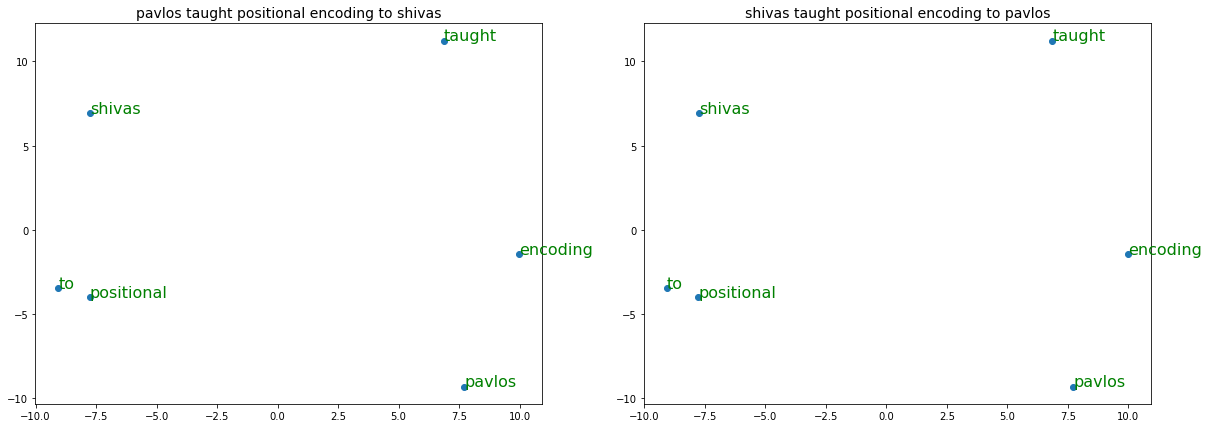

In [ ]:
# Visualize the contextualizied embeddings

# Plot
fig = plt.figure(figsize=(20,7))

axs = fig.add_subplot(1,2,1)
plot_component(axs, component1, sample1, sample1)

axs = fig.add_subplot(1,2,2)
plot_component(axs, component2, sample2, sample2)

plt.show()

Lets jumble the words and see how the contextual embeddings look

In [ ]:
sample3 = "taught to positional shivas pavlos encoding"
sample_tokens3 = text_vectorizer([sample3])
sample_tokens3 = sample_tokens3.numpy()
print(sample_tokens3)

sample4 = "positional pavlos encoding shivas taught to"
sample_tokens4 = text_vectorizer([sample4])
sample_tokens4 = sample_tokens4.numpy()
print(sample_tokens4)

[[516   5 671 569 686 913   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]]
[[671 686 913 569 516   5   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]]


In [ ]:
# Make a prediction on model to get context output
encoder_output3 = model_context_1.predict(sample_tokens3)
print("encoder_output shape:",encoder_output3.shape)

# Make a prediction on model to get context output
encoder_output4 = model_context_1.predict(sample_tokens4)
print("encoder_output shape:",encoder_output4.shape)

1/1 [==============================] - 0s 39ms/step
encoder_output shape: (1, 66, 256)
1/1 [==============================] - 0s 16ms/step
encoder_output shape: (1, 66, 256)


In [ ]:
print(sample3)
print(sample4)
# Get the valid word ignoring padding
num_valid_words = 6
contextual_embedding_3 = encoder_output3[0,:num_valid_words,:]
contextual_embedding_4 = encoder_output4[0,:num_valid_words,:]
print("contextual_embedding_3",contextual_embedding_3.shape)
print("contextual_embedding_4",contextual_embedding_4.shape)

# Reduce dimension using PCA
pca = PCA(n_components=2, random_state=2233)
component3 = pca.fit_transform(contextual_embedding_3.tolist())
pca = PCA(n_components=2, random_state=2233)
component4 = pca.fit_transform(contextual_embedding_4.tolist())
print("component3",component3.shape)
print("component4",component4.shape)

taught to positional shivas pavlos encoding
positional pavlos encoding shivas taught to
contextual_embedding_3 (6, 256)
contextual_embedding_4 (6, 256)
component3 (6, 2)
component4 (6, 2)


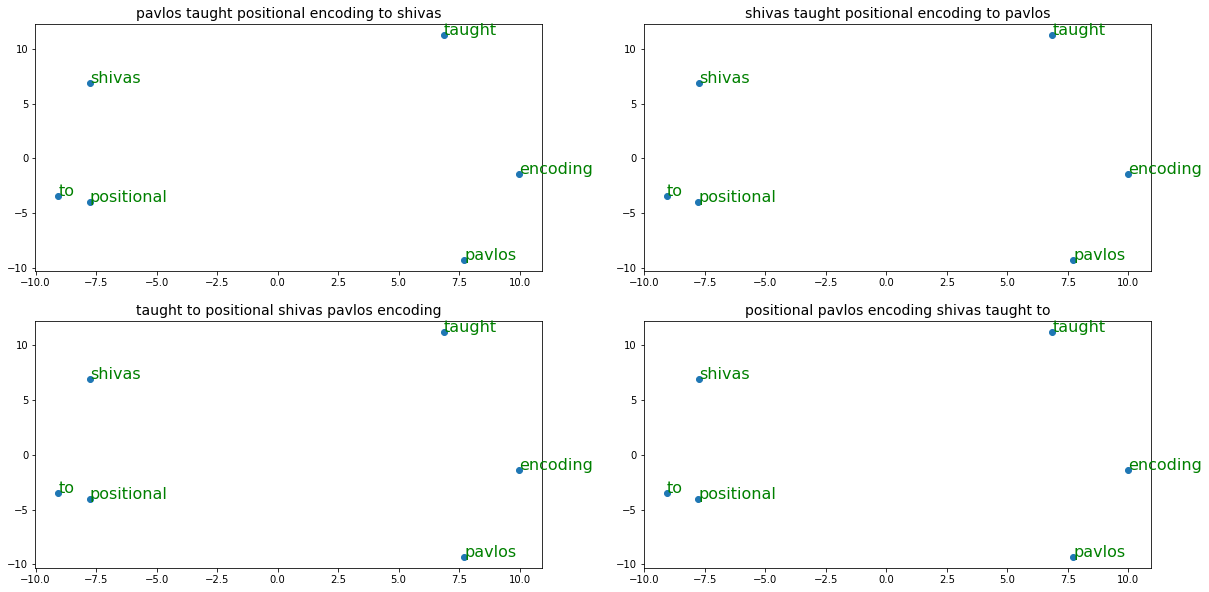

In [ ]:
# Visualize all the contextualizied embeddings

# Plot
fig = plt.figure(figsize=(20,10))

axs = fig.add_subplot(2,2,1)
plot_component(axs, component1, sample1, sample1)

axs = fig.add_subplot(2,2,2)
plot_component(axs, component2, sample2, sample2)

axs = fig.add_subplot(2,2,3)
plot_component(axs, component3, sample3, sample3)

axs = fig.add_subplot(2,2,4)
plot_component(axs, component4, sample4, sample4)

plt.show()

Do you see a problem with these contextual embeddings? How can we resolve this?

<img src="https://storage.googleapis.com/public_colab_images/nlp/multi-head-atten-issues.png" />

**Let us go back to lecture and solve this problem**

<br/>
<br/>
<br/>
<br/>
<br/><br/><br/><br/><br/><br/><br/><br/>
<br/><br/><br/><br/><br/><br/><br/><br/>
<br/><br/><br/><br/><br/><br/><br/><br/>
<br/><br/><br/><br/><br/><br/><br/><br/>
<br/><br/><br/><br/><br/><br/><br/><br/>

---

## **[Positional Encoding](#scrollTo=position_encoding)**

Now lets define a positional encoding function that generate unique values for every sequence position


**Sentence -> Tokens -> Embeddings + Positional Encoding -> MultiHead Attention -> Context Embedding**

The function will follow the following technical details:

<img src="https://storage.googleapis.com/public_colab_images/nlp/positional-encoding-math.png" width="600"/>

In [ ]:
def generate_positional_encoding(max_length, model_size):
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / model_size) for j in range(model_size)]
            if pos != 0
            else np.zeros(model_size)
            for pos in range(max_length)
        ]
    )
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return pos_enc

Test our `generate_positional_encoding(...)` function to see some sample outputs

In [ ]:
# Generate postional encodings for sequence length of 60 and embedding dimension of 256
positional_encodings = generate_positional_encoding(60, 256)
print(positional_encodings.shape)

print("Position 0:",positional_encodings[0][:20])
print("Position 1:",positional_encodings[1][:20])
print("Position 2:",positional_encodings[2][:20])

(60, 256)
Position 0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Position 1: [0.84147098 0.54030231 0.8019618  0.59737533 0.76172041 0.64790587
 0.72141412 0.69250391 0.68156135 0.73176098 0.64255691 0.76623796
 0.60469402 0.79645787 0.56818322 0.82290208 0.53316844 0.84600911
 0.49974046 0.8661752 ]
Position 2: [ 0.90929743 -0.41614684  0.95814438 -0.28628544  0.98704625 -0.16043596
  0.9991642  -0.04087666  0.99748     0.07094825  0.984703    0.17424123
  0.96322662  0.26869029  0.9351183   0.35433567  0.90213071  0.43146283
  0.86572559  0.50051894]


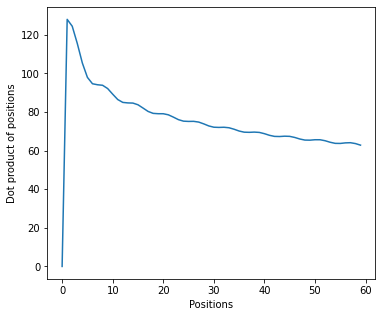

In [ ]:
# Compute the dot product of postion 1 with every other postions
dot_results = []
for idx in range(positional_encodings.shape[0]):
  dot_results.append(np.dot(positional_encodings[1], positional_encodings[idx]))


# Plot the dot product results
fig = plt.figure(figsize=(20,5))
axs = fig.add_subplot(1,3,1)
axs.plot(np.arange(0, positional_encodings.shape[0]), dot_results)
axs.set_xlabel('Positions')
axs.set_ylabel('Dot product of positions')
plt.show()

### **Build/Train Model**

We now will modify the language model we built using "n" Encoder layers. We will add positional encoding to the token embeddings at our input. First we will build a model for training where the output will be a dense layer with number of units = vocabulary size and softmax activation. This will help train the lanaguage model predict the tokens. We will then create a inference model where given an input token sequence the output will be the last encoder layer output (the context embedding)


<img src="https://storage.googleapis.com/public_colab_images/nlp/transformer_simple_lm_with_pe.png" width="800px"/>

In [ ]:
# Free up memory
K.clear_session()

# Model input
model_input = tf.keras.Input(shape=(sequence_length), dtype=tf.int64)

embeddings = tf.keras.layers.Embedding(input_dim=vocabulary_size, output_dim=embedding_dim)(model_input)

###############################################
# Add Postional encoding to the token embedding
embeddings = embeddings + generate_positional_encoding(sequence_length,embedding_dim)
###############################################

# Repeat the output to "n" number of layers
encoder_output = embeddings
for i in range(num_layers):
    encoder_output = EncoderLayer(embed_dim=embedding_dim, dense_dim=ff_dim, num_heads=num_heads)(encoder_output)

# Output Layer
output = tf.keras.layers.Dense(units=vocabulary_size, activation="softmax")(encoder_output)

# Create Model
model_2 = tf.keras.Model(inputs=[model_input], outputs=[output], name="masked_bert_model")

# Print the model architecture
print(model_2.summary())

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = tf.keras.losses.sparse_categorical_crossentropy

# Compile
model_2.compile(optimizer=optimizer, loss=loss)

# Train model
start_time = time.time()
training_results = model_2.fit(
        train_data,
        epochs=epochs,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

Model: "masked_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 66)]              0         
                                                                 
 embedding (Embedding)       (None, 66, 256)           289280    
                                                                 
 tf.__operators__.add (TFOpL  (None, 66, 256)          0         
 ambda)                                                          
                                                                 
 encoder_layer (EncoderLayer  (None, 66, 256)          2236160   
 )                                                               
                                                                 
 encoder_layer_1 (EncoderLay  (None, 66, 256)          2236160   
 er)                                                             
                                                 

### **Evaluation Model**

In [ ]:
# Build a model to output the encoder contexts
model_context_2 = tf.keras.Model(inputs=[model_input], outputs=[encoder_output])

print(model_context_2.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 66)]              0         
                                                                 
 embedding (Embedding)       (None, 66, 256)           289280    
                                                                 
 tf.__operators__.add (TFOpL  (None, 66, 256)          0         
 ambda)                                                          
                                                                 
 encoder_layer (EncoderLayer  (None, 66, 256)          2236160   
 )                                                               
                                                                 
 encoder_layer_1 (EncoderLay  (None, 66, 256)          2236160   
 er)                                                             
                                                             

In [ ]:
# Make a prediction on model to get context output
encoder_output5 = model_context_2.predict(sample_tokens1)
print("encoder_output shape:",encoder_output5.shape)

# Make a prediction on model to get context output
encoder_output6 = model_context_2.predict(sample_tokens2)
print("encoder_output shape:",encoder_output6.shape)

1/1 [==============================] - 0s 233ms/step
encoder_output shape: (1, 66, 256)
1/1 [==============================] - 0s 17ms/step
encoder_output shape: (1, 66, 256)


### **Analyze Context Embeddings**

In [ ]:
print(sample1)
print(sample2)
# Get the valid word ignoring padding
num_valid_words = 6
contextual_embedding_5 = encoder_output5[0,:num_valid_words,:]
contextual_embedding_6 = encoder_output6[0,:num_valid_words,:]
print("contextual_embedding_5",contextual_embedding_5.shape)
print("contextual_embedding_6",contextual_embedding_6.shape)

# Reduce dimension using PCA
pca = PCA(n_components=2, random_state=2233)
component5 = pca.fit_transform(contextual_embedding_5.tolist())
pca = PCA(n_components=2, random_state=2233)
component6 = pca.fit_transform(contextual_embedding_6.tolist())
print("component5",component5.shape)
print("component6",component6.shape)

pavlos taught positional encoding to shivas
shivas taught positional encoding to pavlos
contextual_embedding_5 (6, 256)
contextual_embedding_6 (6, 256)
component5 (6, 2)
component6 (6, 2)


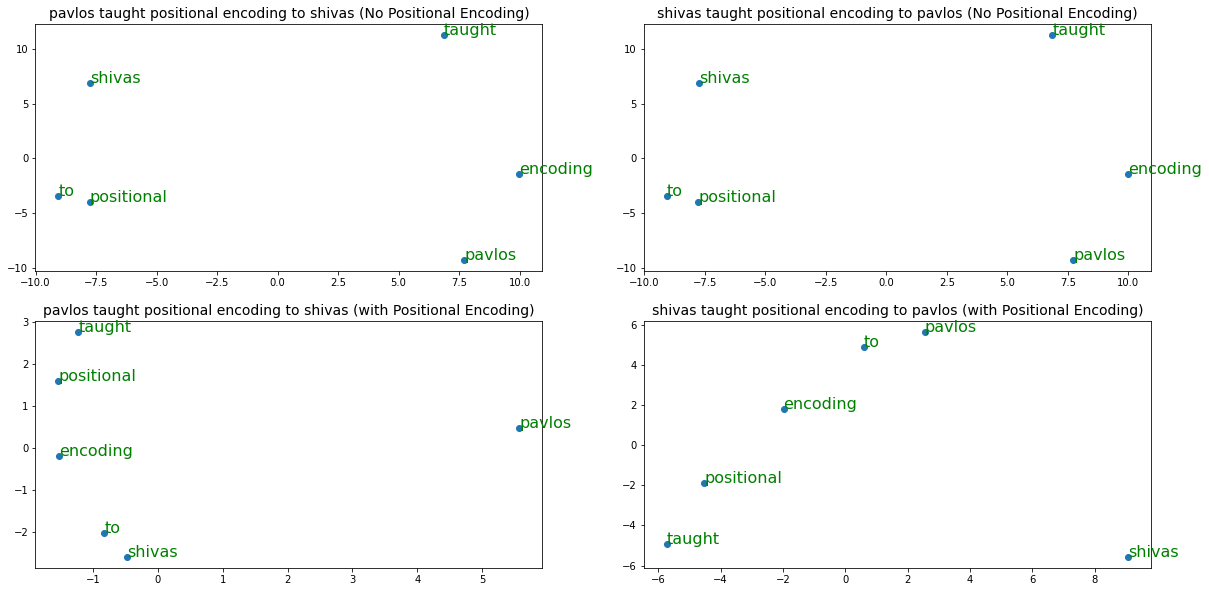

In [ ]:
# Visualize all the contextualizied embeddings

# Plot
fig = plt.figure(figsize=(20,10))

axs = fig.add_subplot(2,2,1)
plot_component(axs, component1,sample1, sample1+" (No Positional Encoding)")

axs = fig.add_subplot(2,2,2)
plot_component(axs, component2,sample2, sample2+" (No Positional Encoding)")

axs = fig.add_subplot(2,2,3)
plot_component(axs, component5,sample1, sample1+" (with Positional Encoding)")

axs = fig.add_subplot(2,2,4)
plot_component(axs, component6,sample2, sample2+" (with Positional Encoding)")

plt.show()